In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

import missingno

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture


from numpy import unique
from numpy import where
import enum

from statsmodels.tsa.stattools import coint


In [150]:
pd.set_option('display.precision', 2)

## Data Cleaning

In [151]:
df = pd.read_csv('equity_data_full')

In [152]:
df.head()

,Unnamed: 0,date,open,high,low,close,adjclose,volume,ticker
0,0,2010-01-04,22.45,22.62,22.26,22.38,20.23,3816656,A
1,1,2010-01-05,22.32,22.33,22.00,22.14,20.01,4187236,A
2,2,2010-01-06,22.06,22.17,22.00,22.06,19.94,3244780,A
3,3,2010-01-07,22.01,22.04,21.81,22.03,19.92,3096026,A
4,4,2010-01-08,21.91,22.06,21.74,22.02,19.91,3735010,A


In [153]:
data = df.pivot(index='date', columns = 'ticker', values = 'adjclose')
data.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.23,19.49,38.66,29.15,NaN,22.17,8.74,17.69,33.42,37.09,...,13.98,19.79,43.66,32.73,NaN,18.84,55.25,28.67,11.43,NaN
2010-01-05,20.01,21.10,38.43,29.20,NaN,22.02,8.53,17.55,33.63,37.70,...,13.81,19.54,43.83,32.34,NaN,18.78,57.00,28.62,11.84,NaN
2010-01-06,19.94,20.47,38.76,28.73,NaN,21.81,8.40,17.64,33.98,37.62,...,13.84,19.41,44.21,32.55,NaN,18.64,56.98,28.40,12.87,NaN
2010-01-07,19.92,20.82,38.75,28.68,NaN,21.46,8.40,17.79,33.95,36.89,...,13.78,19.22,44.07,32.98,NaN,18.64,58.29,27.69,14.31,NaN
2010-01-08,19.91,20.47,38.91,28.87,NaN,21.69,8.23,17.88,33.82,36.69,...,13.79,19.50,43.90,32.98,NaN,18.64,57.06,27.60,14.08,NaN


In [154]:
print('Data Shape before cleaning =', data.shape)

missing_percentage = data.isnull().mean().sort_values(ascending=False)
missing_percentage.head(10)
dropped_list = sorted(list(missing_percentage[missing_percentage > 0.0001].index))
data.drop(labels=dropped_list, axis=1, inplace=True)

print('Data Shape after cleaning =', data.shape)

Data Shape before cleaning = (3007, 505)
Data Shape after cleaning = (3007, 443)


<AxesSubplot:>

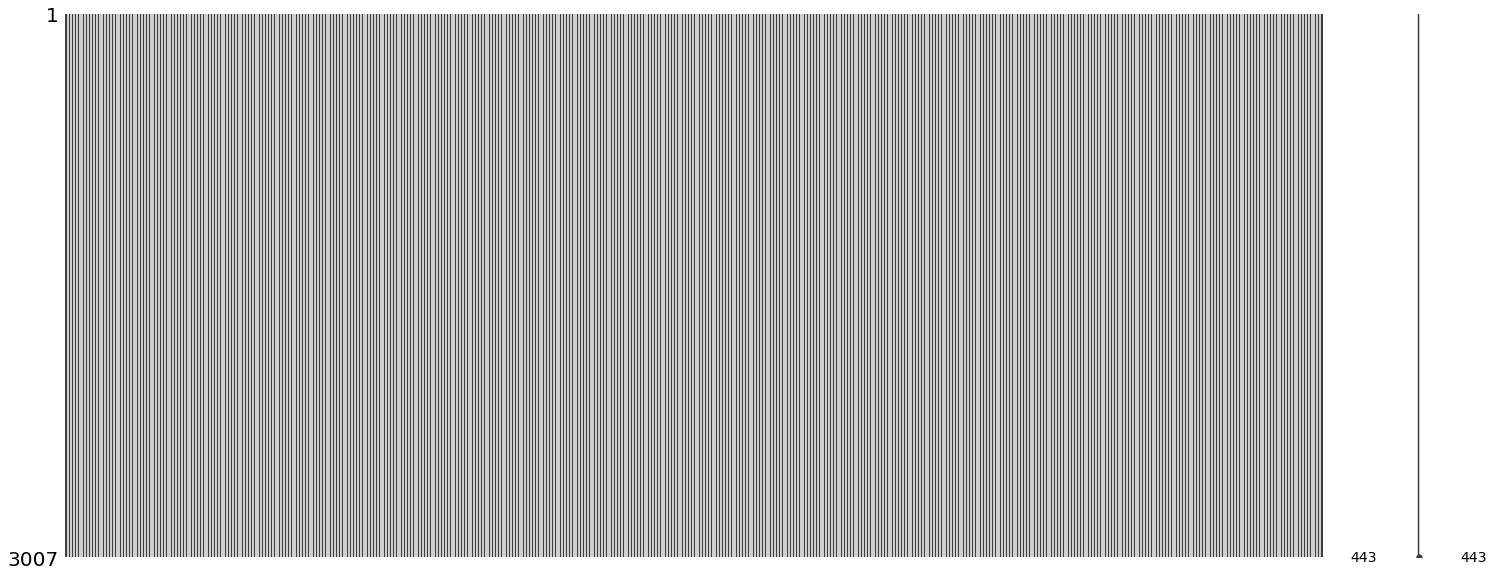

In [155]:
df = df.fillna(method='ffill')
missingno.matrix(data)

In [156]:
adjusted_returns = data.pct_change()
adjusted_returns.drop(index=adjusted_returns.index[0], axis=0, inplace=True)

## Dimentionality Reduction

In [157]:
# Preparing the scaler
scale = StandardScaler().fit(adjusted_returns)

# Fitting the scaler
scale_adjusted_returns = pd.DataFrame(scale.fit_transform(adjusted_returns), columns = adjusted_returns.columns, index=adjusted_returns.index)

In [158]:
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(scale_adjusted_returns.T)
principalDf = pd.DataFrame(data=principalComponents)

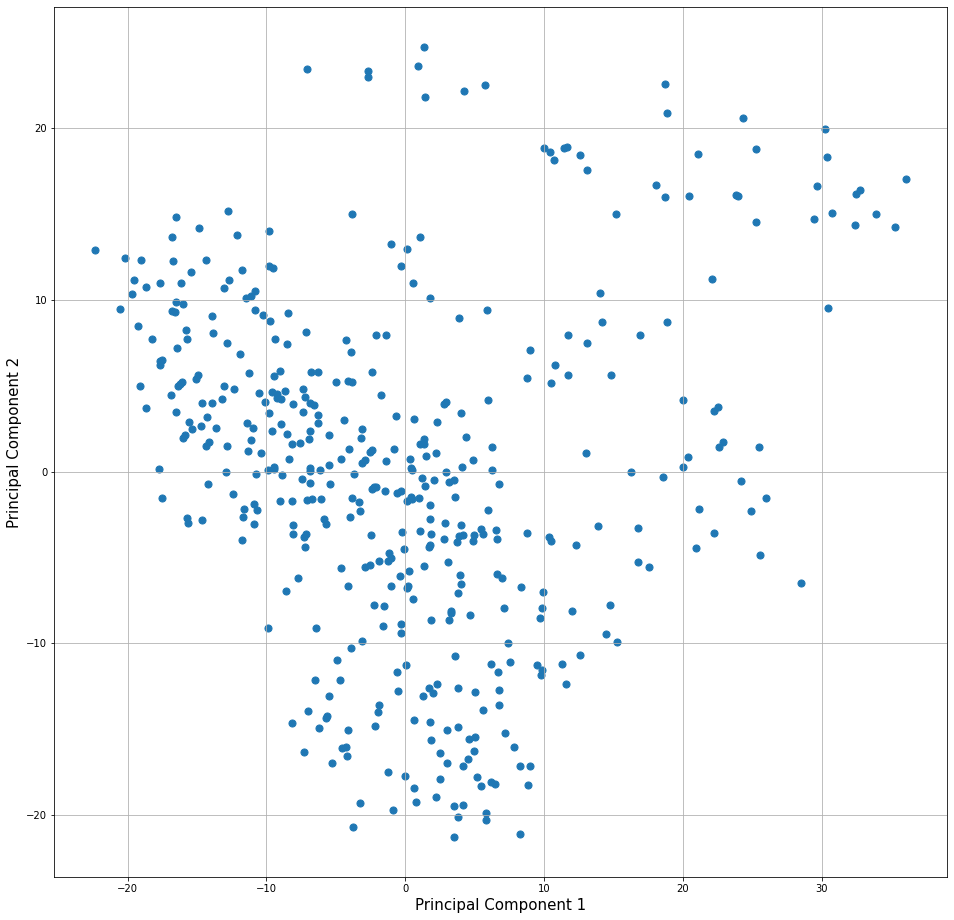

In [ ]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)

ax.scatter(principalDf[0], principalDf[1], s=50)

ax.grid()

In [ ]:
pca.explained_variance_ratio_

array([0.07481652, 0.05466453, 0.02824756, 0.0240259 , 0.0197397 ,
       0.01724163, 0.01472523, 0.01438074, 0.01254161, 0.01168423])

## Unsupervised Learning

In [ ]:
class Clustering_Algo(enum.Enum):
    OPTICS = "OPTICS"
    DBSCAN = "DBSCAN"
    KMEANS = "KMEANS"
    AGG_CLUST = "AGG_CLUST"
    MEAN_SHIFT = "MEAN_SHIFT"
    BIRCH = "BIRCH"
    GAUSSIAN_MIX = "GAUSSIAN_MIX"

In [ ]:
CLUSTERING_ALGO = Clustering_Algo.GAUSSIAN_MIX

In [ ]:
if CLUSTERING_ALGO == Clustering_Algo.OPTICS:
    model = OPTICS(eps=0.9, min_samples=3)
elif CLUSTERING_ALGO == Clustering_Algo.DBSCAN:
    model = DBSCAN(eps=0.9, min_samples=3)
elif CLUSTERING_ALGO == Clustering_Algo.KMEANS:
    model = KMeans(n_clusters=200)
elif CLUSTERING_ALGO == Clustering_Algo.AGG_CLUST:
    model = AgglomerativeClustering(n_clusters=500)
elif CLUSTERING_ALGO == Clustering_Algo.MEAN_SHIFT:
    bandwidth = estimate_bandwidth(principalDf, quantile=0.4, n_samples=2000)
    model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
elif CLUSTERING_ALGO == Clustering_Algo.BIRCH:
    model = Birch(threshold=0.8, n_clusters=250, branching_factor=100)
elif CLUSTERING_ALGO == Clustering_Algo.GAUSSIAN_MIX:
    model = GaussianMixture(n_components=400)

yhat = model.fit_predict(principalDf)
clusters = unique(yhat)

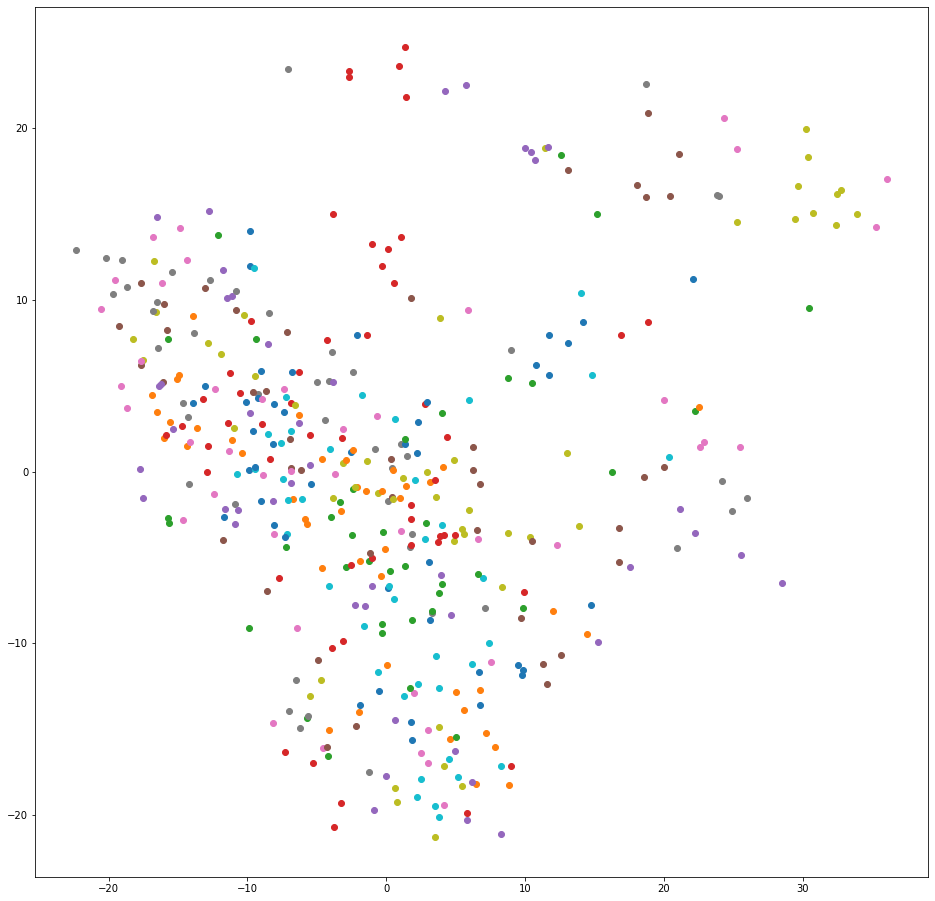

In [ ]:
pyplot.figure(figsize=(16,16))
for cluster in clusters: 
    row = where(yhat == cluster)
    pyplot.scatter(principalDf.iloc[row][0], principalDf.iloc[row][1])

pyplot.show()

## Pair Selection

In [ ]:
def find_cointegrated_pairs(data, significance=0.05):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()

    pairs = []

    for i in range(1):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]

            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))

    return score_matrix, pvalue_matrix, pairs

In [ ]:
cluster_dict = {}
for i, cluster in enumerate(clusters[1:]):
    row = where(yhat == cluster)
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(data.T.iloc[row].T)
    cluster_dict[cluster] = {}
    cluster_dict[cluster]['score_matrix'] = score_matrix
    cluster_dict[cluster]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[cluster]['pairs'] = pairs

pairs = []
for cluster in cluster_dict.keys():
    pairs.extend(cluster_dict[cluster]['pairs'])

print('Number of pairs: ', len(pairs))
print('Out of those pairs, we found %d unique tickers.' % len(np.unique(pairs)))
print(pairs)   

Number of pairs:  24
Out of those pairs, we found 47 unique tickers.
[('CB', 'CINF'), ('IDXX', 'TECH'), ('DHR', 'TMO'), ('CPB', 'K'), ('MCO', 'SPGI'), ('EIX', 'PPL'), ('AMZN', 'CRM'), ('CMI', 'PCAR'), ('IPG', 'RHI'), ('CL', 'KMB'), ('FFIV', 'ZBRA'), ('MPWR', 'TER'), ('ADP', 'PAYX'), ('AEE', 'LNT'), ('EBAY', 'NLOK'), ('EMR', 'PH'), ('RSG', 'WM'), ('ADBE', 'ANSS'), ('AJG', 'BRO'), ('A', 'MTD'), ('AVB', 'EQR'), ('AVB', 'ESS'), ('FIS', 'FISV'), ('AON', 'WLTW')]
